In [1]:
!pip install -q datasets transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have reque

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.chdir("/content/drive/MyDrive/assignment")

In [4]:
from datasets import load_dataset

data = load_dataset('data')
# data


Resolving data files:   0%|          | 0/1106 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/300 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-5-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


In [6]:
data["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['bordered', 'borderless', 'row_bordered'], id=None)}

In [7]:
data["train"].features["label"]

ClassLabel(names=['bordered', 'borderless', 'row_bordered'], id=None)

In [8]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'row_bordered'

In [9]:
from transformers import AutoImageProcessor

model_name = 'google/vit-base-patch16-224-in21k'
image_processor  = AutoImageProcessor.from_pretrained(model_name)
image_processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [10]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)


In [11]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [12]:
train = data['train']
val = data['validation']

In [13]:
train.set_transform(preprocess_train)
val.set_transform(preprocess_val)

In [14]:
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=2115x492>,
 'label': 0,
 'pixel_values': tensor([[[-1.0000, -1.0000, -0.8667,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9373, -1.0000, -0.9529,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8353, -1.0000, -0.9451,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 0.7333,  0.7333,  0.7333,  ...,  0.7333,  0.7333,  0.7333],
          [-0.7647, -0.7647, -0.7647,  ..., -0.7647, -0.7647, -0.7647],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -0.8667,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9373, -1.0000, -0.9529,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8353, -1.0000, -0.9451,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 0.7333,  0.7333,  0.7333,  ...,  0.7333,  0.7333,  0.7333],
          [-0.7647, -0.7647, -0.7647,  ..., -0.7647, -0.7647, -0.7647],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 

In [15]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_name,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model.to("cuda")

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [17]:
# model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-table-data-version-2",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [19]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [20]:
args.device

device(type='cuda', index=0)

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [22]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy
0,1.045000,0.805132,0.653333
2,0.247900,0.274218,0.933333
4,0.180500,0.141240,0.986667
6,0.169900,0.162679,0.966667
7,0.130800,0.149954,0.966667


***** train metrics *****
  epoch                    =      7.7714
  total_flos               = 621100924GF
  train_loss               =       0.321
  train_runtime            =  0:26:12.00
  train_samples_per_second =       5.628
  train_steps_per_second   =       0.087


In [23]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =     7.7714
  eval_accuracy           =     0.9867
  eval_loss               =     0.1412
  eval_runtime            = 0:00:07.62
  eval_samples_per_second =     19.679
  eval_steps_per_second   =      1.312


## Inference

In [25]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

# repo_name = "/content/drive/MyDrive/assignment/google/vit-base-patch16-224-in21k-finetuned-eurosat"
repo_name = "/content/drive/MyDrive/assignment/google/vit-base-patch16-224-in21k-finetuned-table-data-version-2"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
modelfinetuned = AutoModelForImageClassification.from_pretrained(repo_name)

In [26]:
test = data['test']

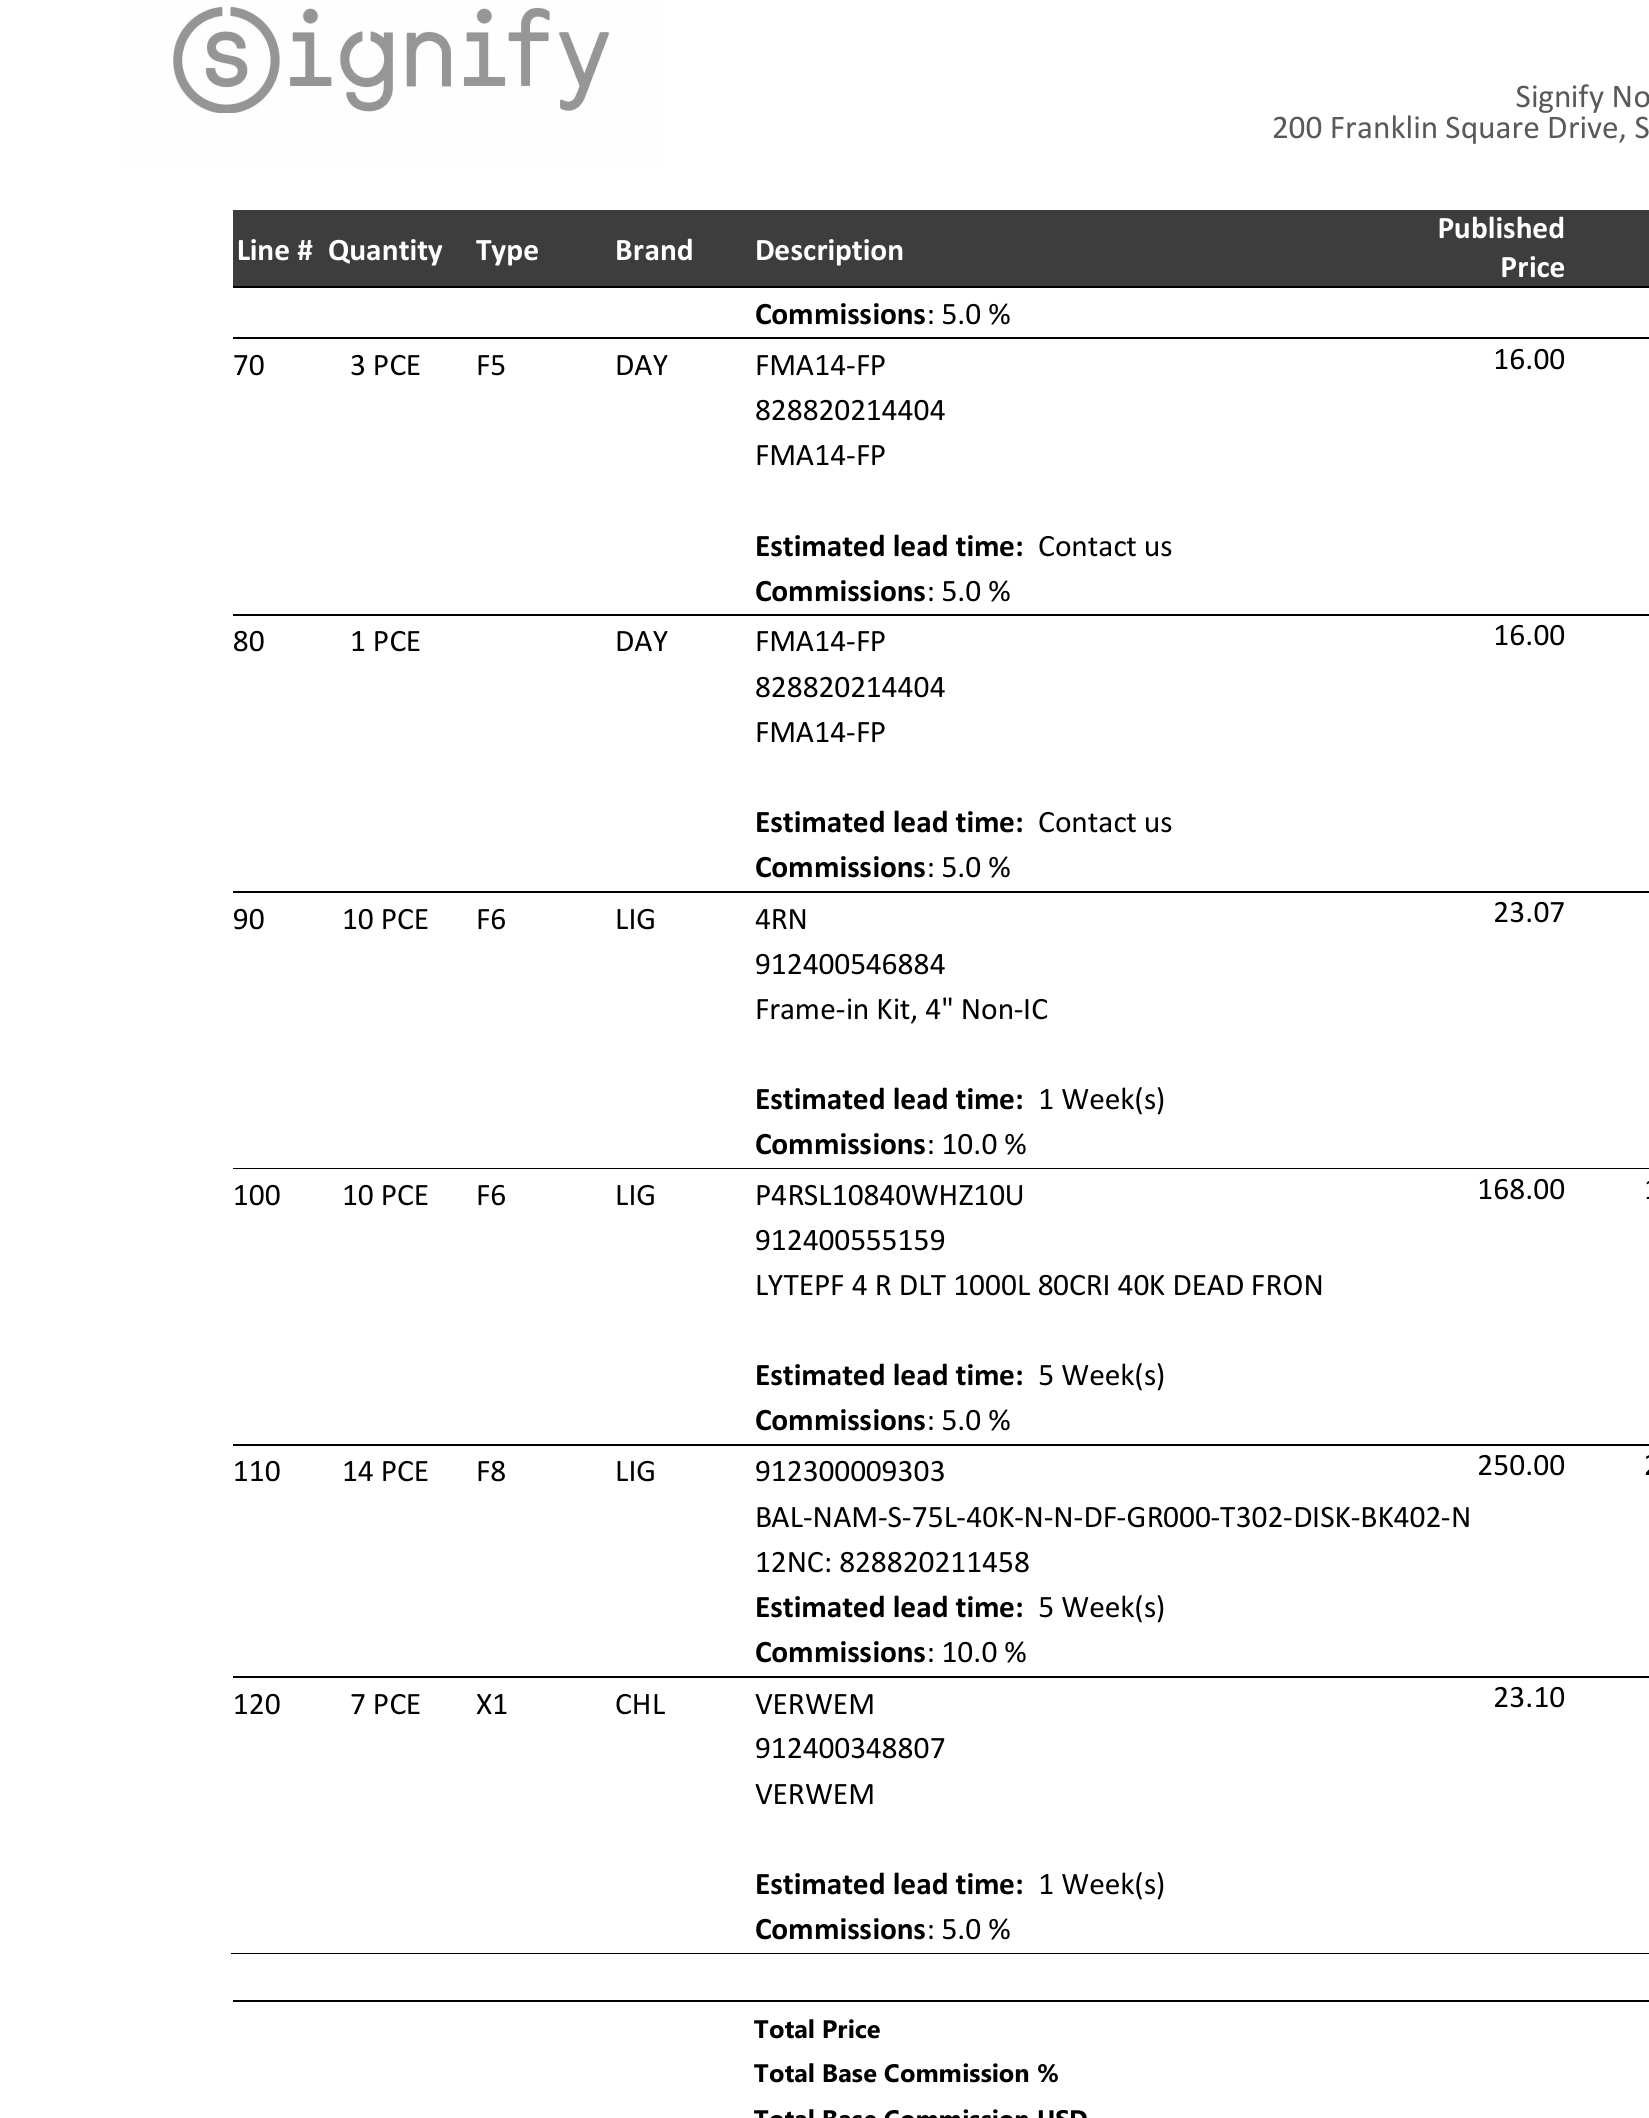

In [27]:
test[201]['image']

In [28]:
test[101]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=1602x438>,
 'label': 1}

In [32]:
from tqdm.auto import tqdm

In [33]:
true = []
predicted = []
for i in tqdm(range(len(test))):
  encoding = image_processor(test[i]['image'].convert("RGB"), return_tensors="pt")
    # forward pass
  with torch.no_grad():
      outputs = modelfinetuned(**encoding)
      logits = outputs.logits
  predicted_class_idx = logits.argmax(-1).item()
  predicted.append(predicted_class_idx)
  true.append(test[i]['label'])

  0%|          | 0/300 [00:00<?, ?it/s]

In [34]:
!pip install -q scikit-learn

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(true, predicted)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true, predicted)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 96.67%
Confusion Matrix:
[[100   0   0]
 [  0  99   1]
 [  7   2  91]]
